# Labels mapping characteristics and filtering

Depending on the quality of your segmentation, it will be interesting to filter your labels based on different characteristics of your dataset, like size, intensity, etc.

In this case, the result using stardist and a generalistic ML confidence-based pixel classifier generates an over-segmentation. This issue will be easily solved by setting a mean intensity threshold to remove the low-intensity labels representing negative signal cells.

### Setting up your requirements

We will use 'NumPy' to handle our arrays, 'napari' to visualize our data, 'Zarr' to load and save our results.

Also, we will use two functions from 'scikit-image', 'measure_regionprops_table' to list the properties of our labels based on the raw data, and 'util_map_array' to extract the labels that we want. 'pandas' is going to be used to handle the extracted statistics.

Last, we use 'matplotlib' to plot some graphs that will help us decide the limits to select the labels.

In [1]:
import numpy as np
import napari
import pandas
import zarr
import matplotlib.pyplot as plt
#import tiffile as tf
#from skimage.measure import regionprops_table
from skimage.util import map_array
from napari_cupy_image_processing import measurements
#from napari_simpleitk_image_processing import label_statistics

### Loading your data
Here you have to indicate where your files are stored, you can use zarr format that will result in smaller and manageable files, but you can use tif files in the same way.

In [2]:
# load raw data

image = zarr.load("D:\EHG\Explants\INSL3\C2-eh3931_cyclo25_explant-1_5-couptfii_6-insl3_7-cyp17a1-1s_12x_1z_blaze_C0.ome_Processed.aivia_Processed.aivia.tif56.zarr")
#image = tf.imread(r"F:\stardist_seg\raw.tif")

# Load the segmented image

labels = zarr.load("D:\EHG\Explants\INSL3\Labels\C2-eh3931_cyclo25_explant-1_5-couptfii_6-insl3_7-cyp17a1-1s_12x_1z_blaze_C0.ome_Processed.aivia_Processed.aivia_cp_masks.tif20.zarr")
#labels = tf.imread(r"F:\stardist_seg\labels.tif")

#intensity_labels = zarr.load(r"F:\stardist_seg\lab_intensity.zarr")

### Inspect your data using Napari

We are going to use Napari to visualize our data

In [12]:
viewer = napari.Viewer()

C:\Users\Linux\.conda\envs\bio11\lib\site-packages\napari_tools_menu\__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Then, we add the datasets to Napari

In [13]:
viewer.add_image(image)
viewer.add_labels(labels)
#viewer.add_labels(intensity_labels)

C:\Users\Linux\.conda\envs\bio11\lib\weakref.py:355: RuntimeWarning: coroutine 'get_msg' was never awaited
  self._iterating = set()


<Labels layer 'labels' at 0x11e121b12e0>

### Extracting the labels features

Using the 'regioprops_table' function, we can extract some label characteristics that will help us to decide which threshold can be applied for or case. 


In [ ]:
def measurements(
        image_layer : viewer.layers['image'],
        labels_layer: viewer.layers['labels'],
        napari_viewer : napari.Viewer = None,
        size: bool = True,
        intensity: bool = True,
        position: bool = False):
    
    import cupy
    from cupyx.scipy import ndimage

    if image_layer is not None and labels_layer is not None:

        labels = cupy.asarray(labels_layer.data)
        image = cupy.asarray(image_layer.data).astype(np.float32)

        df = {}

        for l in range(1, labels.max().get() + 1):
            _append_to_column(df, "label", l)
            if position:
                for i, x in enumerate(ndimage.center_of_mass(image, labels, l)):
                    _append_to_column(df, "center_of_mass_" + str(i), x.get())
                for i, x in enumerate(ndimage.minimum_position(image, labels, l)):
                    _append_to_column(df, "minimum_position_" + str(i), x)
                for i, x in enumerate(ndimage.maximum_position(image, labels, l)):
                    _append_to_column(df, "maximum_position_" + str(i), x)

            mean = None
            if intensity:
                x = ndimage.mean(image, labels, l)
                mean = x.get()
                _append_to_column(df, "mean", x.get())
                x = ndimage.minimum(image, labels, l)
                _append_to_column(df, "minimum", x.get())
                x = ndimage.maximum(image, labels, l)
                _append_to_column(df, "maximum", x.get())
                x = ndimage.median(image, labels, l)
                _append_to_column(df, "median", x.get())
                x = ndimage.standard_deviation(image, labels, l)
                _append_to_column(df, "standard_deviation", x.get())

            if size:
                sum_labels = ndimage.sum_labels(image, labels, l).get()
                if mean is None:
                    mean = ndimage.mean(image, labels, l).get()
                pixel_count = sum_labels / mean
                _append_to_column(df, "pixel_count", pixel_count)

        result = {}
        for k, v in df.items():
            result[k] = np.asarray(v).tolist()

        return result
        

def _append_to_column(dictionary, column_name, value):
    if column_name not in dictionary.keys():
        dictionary[column_name] = []
    dictionary[column_name].append(value)

In [3]:
props = measurements(image, labels)

Then, we can use pandas to structure the results array.

In [4]:
content = pandas.DataFrame(props)
content

,label,mean,minimum,maximum,median,standard_deviation,pixel_count
0,1,1183.012320,108.0,2087.0,1253.0,421.316895,487.0
1,2,1730.654618,1444.0,2327.0,1704.0,139.557332,249.0
2,3,1546.525773,1362.0,1776.0,1537.0,101.404779,97.0
3,4,1375.880000,1217.0,1556.0,1375.0,70.344591,125.0
4,5,1383.360769,806.0,2141.0,1395.0,289.586166,1300.0
...,...,...,...,...,...,...,...
2376,2377,1346.992000,1149.0,1542.0,1351.0,82.770671,125.0
2377,2378,1554.818182,1346.0,1700.0,1556.0,70.597990,110.0
2378,2379,1502.434211,1317.0,1661.0,1495.0,87.175611,76.0
2379,2380,665.346939,465.0,857.0,670.0,73.165049,49.0


We can retrieve the different vectors of interest to be evaluated.

In [5]:
max_vector = content['maximum']
mean_vector = content['mean']
min_vector = content['minimum']
sol_vector = content['median']

Then, we can get a look of our labels using matplotlib to plot the frequency histograms.

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

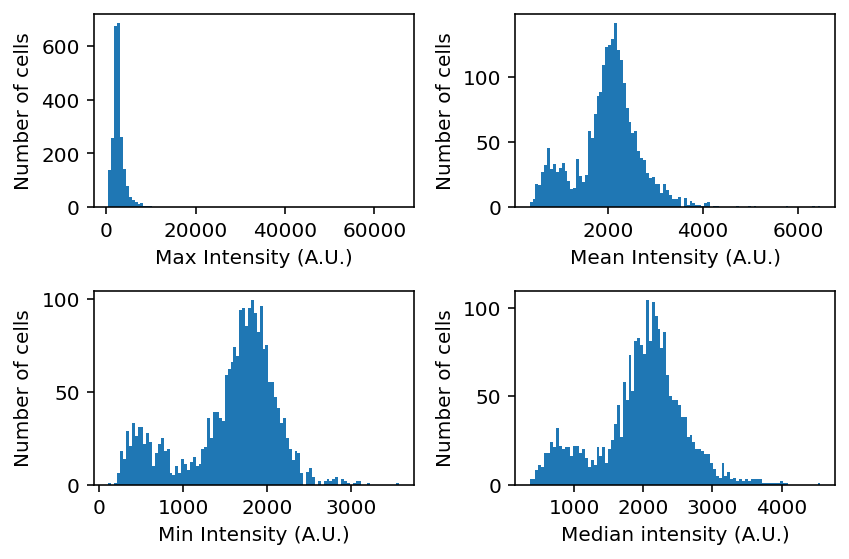

In [7]:
fig, axes = plt.subplots(2, 2)
ax = axes.ravel()

ax[0].hist(max_vector, bins=100)
ax[0].set_ylabel('Number of cells')
ax[0].set_xlabel('Max Intensity (A.U.)')

ax[1].hist(mean_vector, bins=100)
ax[1].set_ylabel('Number of cells')
ax[1].set_xlabel('Mean Intensity (A.U.)')

ax[2].hist(min_vector, bins=100)
ax[2].set_ylabel('Number of cells')
ax[2].set_xlabel('Min Intensity (A.U.)')

ax[3].hist(sol_vector, bins=100)
ax[3].set_ylabel('Number of cells')
ax[3].set_xlabel('Median intensity (A.U.)') 

fig.tight_layout()

From those histograms we can see that there are two populations of cells, this allow us to think that cells that have a instensity of 4000 or higher ca be considerated positives.

### Selecting labels above a given intensity threshold

To generate the labels image of the nuclei with an intensity higher than 4000 we can use the 'map_array' funtion from 'scikit-image' mapping the *product* of the boolean array with the labels.

In [8]:
intensity_labels = map_array(
    labels,
    label_ids := np.asarray(content['label']),
    label_ids * np.asarray(content['mean'] > 1500),
)

Then we can add our new labels to Napari

In [14]:
viewer.add_labels(intensity_labels)

<Labels layer 'intensity_labels' at 0x11e1ea8a280>

### Saving the new labels

We can save our new generated labels as *zarr* file using the 'convenience.save' function

In [9]:
zarr.convenience.save(r"D:\EHG\Explants\INSL3\results\eh3931_cyclo25_explant-insl3.zarr", intensity_labels)

### Getting the properties of the new set of labels
Finally, we can extract the properties of our new set of labels and format them with pandas

In [11]:
props_int = measurements(image, intensity_labels)

ValueError: zero-size array to reduction operation cupy_min which has no identity

In [ ]:
content_int = pandas.DataFrame(props_int)
content_int

Here, we can see that we count finally *31439* cells in the dataset